The paper: https://doi.org/10.1016/j.ibmed.2024.100188

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import IPython.display as display
from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split

tf.random.set_seed(42)

print("Tensorflow version: ", tf.__version__)
print("Keras version: ", tfk.__version__)
print("Is GPU detected: ", len(tf.config.list_physical_devices('GPU'))>0)

Tensorflow version:  2.17.1
Keras version:  3.5.0
Is GPU detected:  True


## Load dataset

In [2]:
data = np.load('/kaggle/input/lung-cancer/lung_dataset_interpolated.npz')
full_slices = data['full_slices']
nodules = data['nodules']
tumor_classes = data['tumor_classes']

print("full_slices shape: ", full_slices.shape)
print("nodules shape: ", nodules.shape)
print("tumor_classes shape: ", tumor_classes.shape)

full_slices shape:  (2363, 512, 512)
nodules shape:  (2363, 138, 138)
tumor_classes shape:  (2363,)


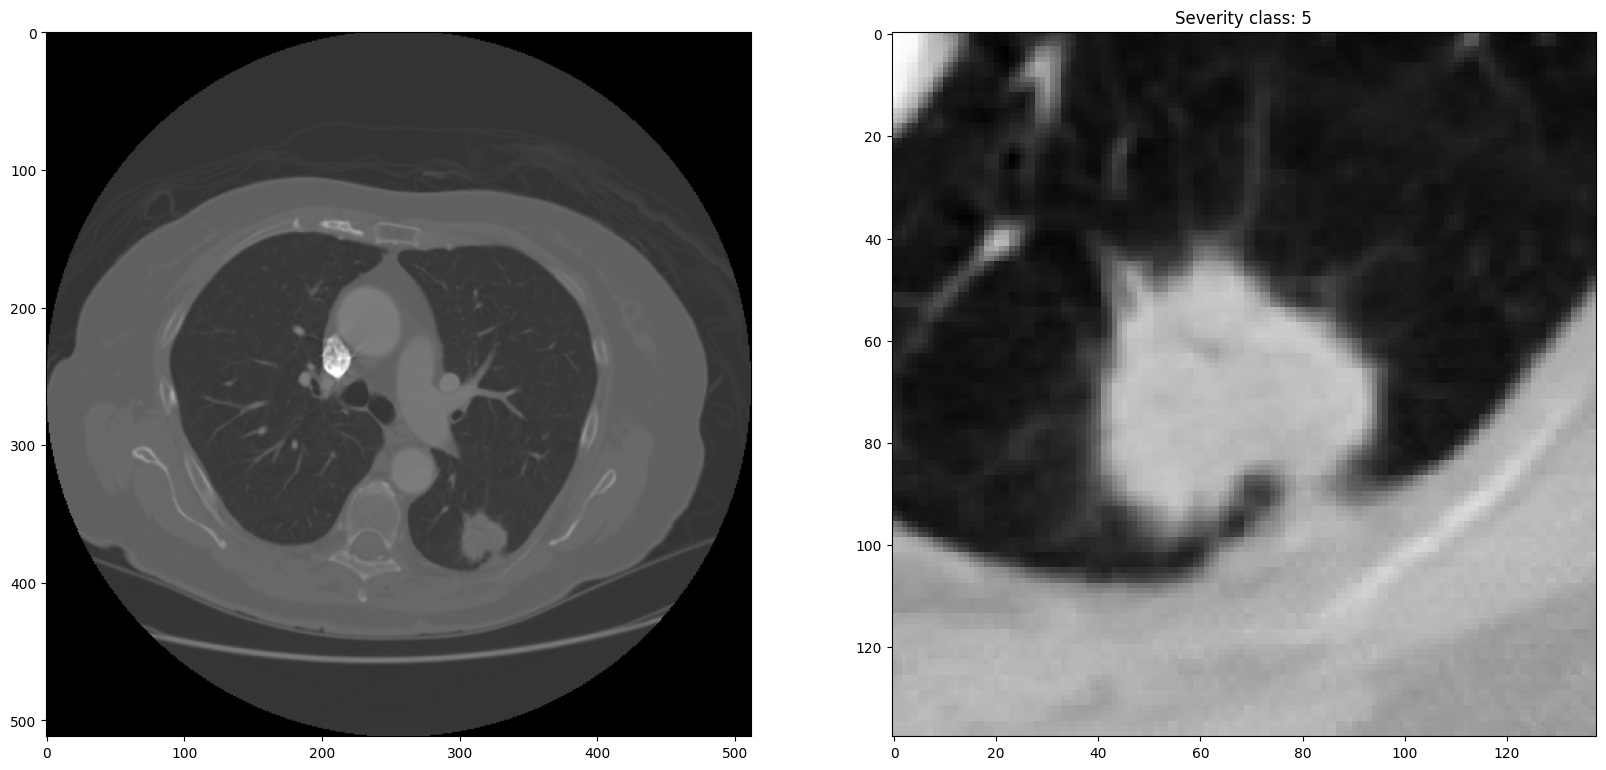

In [3]:
IMAGE_IDX = 0

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title(f"Severity class: {tumor_classes[IMAGE_IDX]}")

ax1.imshow(full_slices[IMAGE_IDX], cmap='gray')
ax2.imshow(nodules[IMAGE_IDX], cmap='gray')

plt.show()

# Data preprocessing

In [4]:
# Normalize to values between 0 and 255
nodules = (nodules - np.min(nodules)) / (np.max(nodules) - np.min(nodules))*255
nodules = np.ceil(nodules).astype('uint8')

In [5]:
import cv2 as cv

clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
kernel = np.ones((3, 3), np.uint8)

def img_enhancer(img):
    img = cv.medianBlur(img, 3)
    img = cv.equalizeHist(img)
    img = clahe.apply(img)
    img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
    return img

def img_enhancer_logger(img):
    def plot_image(image, title='Image'):
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.show()

    plot_image(img)
    img = cv.medianBlur(img, 3)
    plot_image(img)
    img = cv.equalizeHist(img)
    plot_image(img)
    img = clahe.apply(img)
    plot_image(img)
    img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
    plot_image(img)
    return img

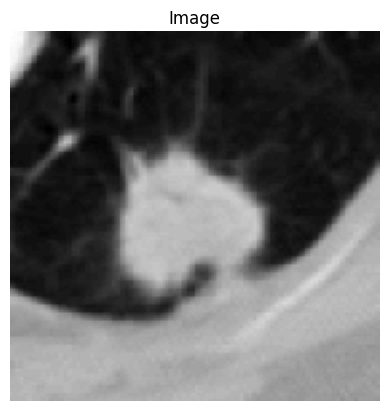

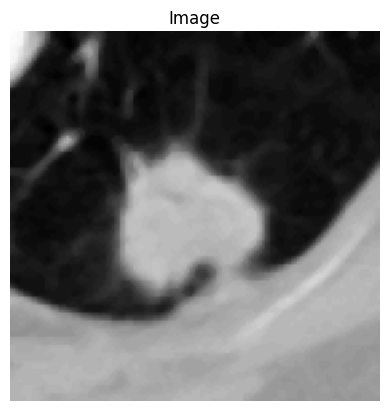

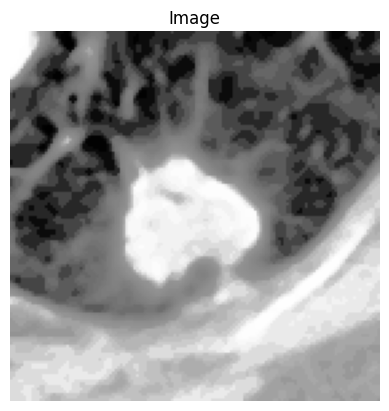

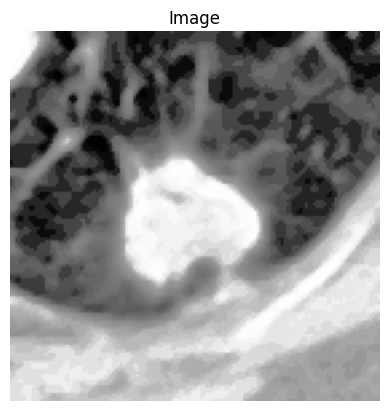

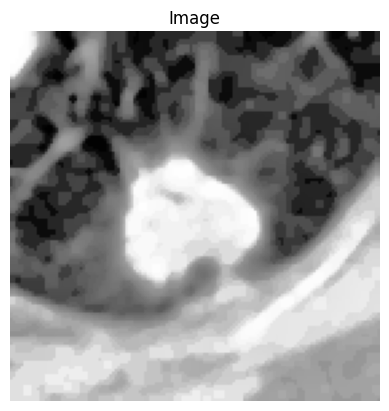

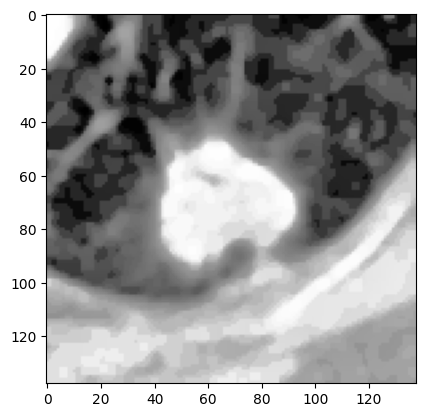

In [6]:
plt.title('After "enhancements"')
plt.imshow(img_enhancer_logger(nodules[IMAGE_IDX]), cmap='gray')
plt.show()

In [7]:
# Enhance the images

processed_images = []
for img in nodules:
    img = img_enhancer(img)
    processed_images.append(img)

nodules = np.array(processed_images)

In [8]:
# subtract 1 from the class encoding because to_categorical expects starting index = 0
label_set = tfk.utils.to_categorical(tumor_classes - 1, num_classes=5)
label_set

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [9]:
def calculate_class_weight(Y):
    from sklearn.utils.class_weight import compute_class_weight

    y_integers = np.argmax(Y, axis=1)
    return compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)    

[1.93688525 1.03413567 0.43278388 1.13062201 3.10921053]


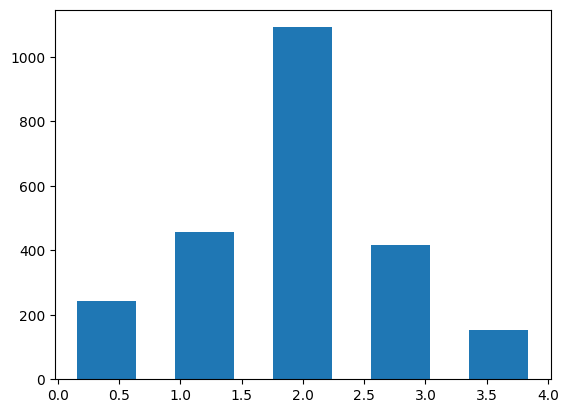

In [10]:
# Starting class weights (inverse frequencies)
class_weights = calculate_class_weight(label_set)

plt.hist(np.argmax(label_set, -1), bins=5,rwidth=0.6)
print(class_weights)

# d_class_weights = dict(enumerate(class_weights))

# import json # Just to prettify the debug
# print(json.dumps(d_class_weights, sort_keys=True, indent=1))

[1.00119798 0.99274773 0.96941392 0.94970096 1.09965374]
{
 "0": 1.0011979823455233,
 "1": 0.9927477336667708,
 "2": 0.9694139194139194,
 "3": 0.949700956937799,
 "4": 1.0996537396121884
}


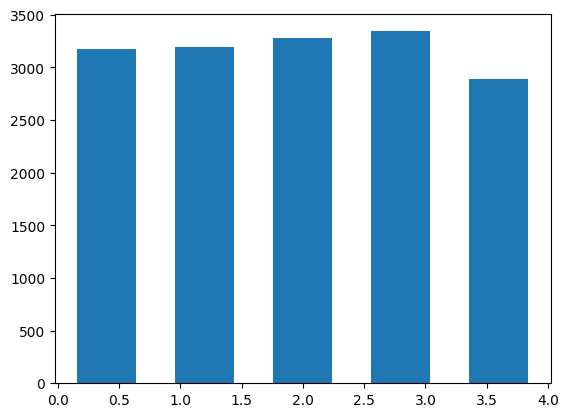

In [11]:
# Balance the dataset by applying random rotations
nodules = np.expand_dims(nodules, -1)

X_bal, y_bal = [], []
X_bal.extend(nodules)
y_bal.extend(label_set)

while class_weights[4] > 1 + 0.1:
    # Repeat this while last class (the minority one) is "infrequent"
    for x, y in zip(nodules, label_set):
        
        # Apply augmentation if class is infrequent
        if class_weights[np.argmax(y)] > 1:
            # Just rotation to not mess up too much the image distribution (thankfully they're only slices of the CT) 
            x = tfkl.RandomRotation(0.9)(x)
            X_bal.append(x)
            y_bal.append(y)
    
    # Recalculate weights
    class_weights = calculate_class_weight(y_bal)

X_balanced, y_balanced = np.asarray(X_bal), np.asarray(y_bal)

plt.hist(np.argmax(y_balanced, -1), bins=5,rwidth=0.6)
print(class_weights)


# These lines are now useless but ok
d_class_weights = dict(enumerate(class_weights))

import json # Just to prettify the debug
print(json.dumps(d_class_weights, sort_keys=True, indent=1))

In [12]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, shuffle=True)

X_train = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
X_test = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test))

print("Training set shape: ", X_train.shape, y_train.shape)
print("Test set shape: ", X_test.shape, y_test.shape)

print("Train/Test mins ", np.min(X_train), np.min(X_test))
print("Train/Test maxs ", np.max(X_train), np.max(X_test))

Training set shape:  (11115, 138, 138, 1) (11115, 5)
Test set shape:  (4764, 138, 138, 1) (4764, 5)
Train/Test mins  0.0 0.0
Train/Test maxs  1.0 1.0


In [13]:
def perform_augmentation(X, Y, p):
    X_aug, y_aug = [], []
    for x, y in tqdm(zip(X, Y), total=len(X), desc="Augmenting data"):
        X_aug.append(x)
        y_aug.append(y)

        if np.random.random() < p: # random rotate the image and add it
            # It would be better to apply these independently
            x = tfkl.RandomRotation(0.9)(x)
            x = tfkl.RandomFlip()(x)
            x = tfkl.RandomTranslation(0.3, 0.3)(x)
            X_aug.append(x)
            y_aug.append(y)

    return np.asarray(X_aug), np.asarray(y_aug)

In [14]:
# Repeated training set augmentation for laughs
X_aug, y_aug = perform_augmentation(X_train, y_train, 0.75)
X_aug, y_aug = perform_augmentation(X_aug, y_aug, 0.2)

print("Augmented training set shape: ", X_aug.shape, y_aug.shape)

Augmenting data: 100%|██████████| 19454/19454 [01:52<00:00, 172.66it/s]


Augmented training set shape:  (23419, 138, 138, 1) (23419, 5)


## Model definition

In [15]:
def build_model(filters):
    f1, f2, f3, f4 = filters

    inputs = tfkl.Input(shape=(138, 138, 1), name='input')

    x = tfkl.Conv2D(f1, kernel_size=3, activation='relu', name="conv_1")(inputs)
    x = tfkl.MaxPooling2D(name="max_pool_1")(x)
    x = tfkl.SpatialDropout2D(0.2, name="spatial_dropout_1")(x)
    
    x = tfkl.Conv2D(f2, kernel_size=3, name="conv_2")(x)
    x = tfkl.BatchNormalization(name="batch_norm_2")(x)
    x = tfkl.ReLU(name="relu_activation_2")(x)
    x = tfkl.MaxPooling2D(name="max_pool_2")(x)
    x = tfkl.SpatialDropout2D(0.3, name="spatial_dropout_2")(x)

    x = tfkl.Conv2D(f3, kernel_size=3, name="conv_3")(x)
    x = tfkl.BatchNormalization(name="batch_norm_3")(x)
    x = tfkl.ReLU(name="relu_activation_3")(x)
    x = tfkl.MaxPooling2D(name="max_pool_3")(x)
    x = tfkl.SpatialDropout2D(0.3, name="spatial_dropout_3")(x)

    x = tfkl.Conv2D(f4, kernel_size=3, activation='relu', name="conv_4")(x)
    x = tfkl.SpatialDropout2D(0.4, name="spatial_droput_4")(x) # Since no hidden dense layers

    x = tfkl.GlobalAveragePooling2D(name="global_avg_pooling")(x)
    x = tfkl.Dense(5, activation="softmax")(x)
    

    model = tfk.Model(inputs = inputs, outputs = x, name="test-model")
    model.summary(expand_nested=True, show_trainable=True)
    return model

In [16]:
# Custom callback class for real-time plotting
class RealTimePlot(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        # Initialize the lists that will store the metrics
        self.epochs = []
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

        # Set up the plot
        self.fig, (self.ax_loss, self.ax_acc) = plt.subplots(1, 2, figsize=(14, 5))
        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        # Append the metrics to the lists
        self.epochs.append(epoch)
        self.train_loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.train_acc.append(logs['accuracy'])
        self.val_acc.append(logs['val_accuracy'])

        # Clear the previous output
        display.clear_output(wait=True)

        # Plot training and validation loss
        self.ax_loss.clear()
        self.ax_loss.plot(self.epochs, self.train_loss, label='Training Loss')
        self.ax_loss.plot(self.epochs, self.val_loss, label='Validation Loss')
        self.ax_loss.set_title('Training and Validation Loss')
        self.ax_loss.set_xlabel('Epoch')
        self.ax_loss.set_ylabel('Loss')
        #self.ax_loss.set_ylim(top=2.5, bottom=0.0)
        self.ax_loss.legend()

        # Plot training and validation accuracy
        self.ax_acc.clear()
        self.ax_acc.plot(self.epochs, self.train_acc, label='Training Accuracy')
        self.ax_acc.plot(self.epochs, self.val_acc, label='Validation Accuracy')
        self.ax_acc.set_title('Training and Validation Accuracy')
        self.ax_acc.set_xlabel('Epoch')
        self.ax_acc.set_ylabel('Accuracy')
        self.ax_acc.legend()

        # Redraw the updated plots
        display.display(self.fig)
        plt.pause(0.1)

In [17]:
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max', 
    patience=50,
    restore_best_weights=True
)

In [18]:
model = build_model(filters=(64, 64, 128, 256))
model.compile(
    loss=tfk.losses.CategoricalFocalCrossentropy(alpha=list(d_class_weights.values())),
    optimizer=tfk.optimizers.AdamW(),
    metrics=['accuracy']
)

Model: "test-model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input (InputLayer)                  │ (None, 138, 138, 1)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv_1 (Conv2D)                     │ (None, 136, 136, 64)         │           640 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pool_1 (MaxPooling2D)           │ (None, 68, 68, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ spatial_dropout_1                   │ (None, 68, 68, 64)           │             0 │    -    │
│ (SpatialDropout2D)                  │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv_2 (Conv2D)                     │ (None, 66, 66, 64)           │        36,928 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_norm_2 (BatchNormalization)   │ (None, 66, 66, 64)           │           256 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu_activation_2 (ReLU)            │ (None, 66, 66, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pool_2 (MaxPooling2D)           │ (None, 33, 33, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ spatial_dropout_2                   │ (None, 33, 33, 64)           │             0 │    -    │
│ (SpatialDropout2D)                  │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv_3 (Conv2D)                     │ (None, 31, 31, 128)          │        73,856 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ batch_norm_3 (BatchNormalization)   │ (None, 31, 31, 128)          │           512 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ relu_activation_3 (ReLU)            │ (None, 31, 31, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ max_pool_3 (MaxPooling2D)           │ (None, 15, 15, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ spatial_dropout_3                   │ (None, 15, 15, 128)          │             0 │    -    │
│ (SpatialDropout2D)                  │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv_4 (Conv2D)                     │ (None, 13, 13, 256)          │       295,168 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ spatial_droput_4 (SpatialDropout2D) │ (None, 13, 13, 256)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_avg_pooling                  │ (None, 256)                  │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)        

 Total params: 408,645 (1.56 MB)

 Trainable params: 408,261 (1.56 MB)

 Non-trainable params: 384 (1.50 KB)

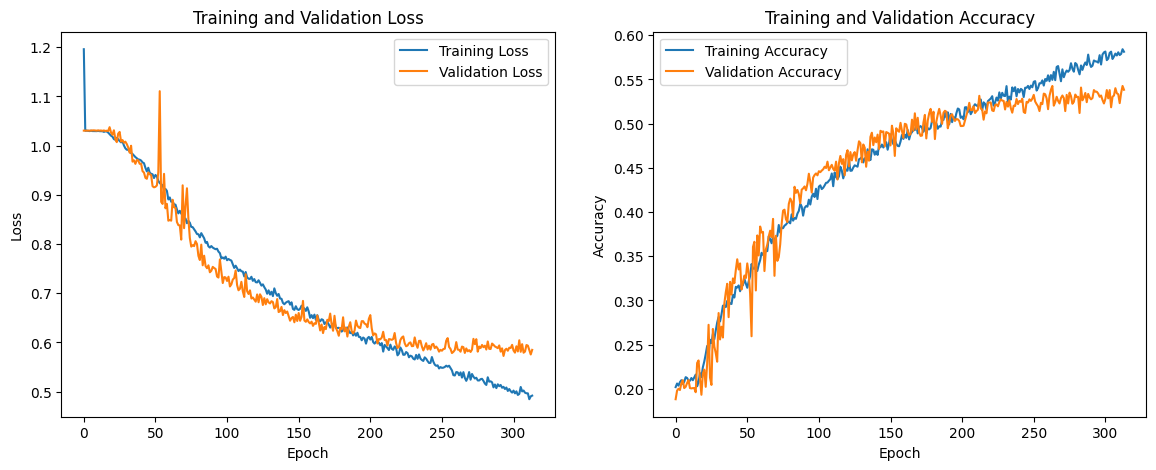

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.5871 - loss: 0.4889 - val_accuracy: 0.5383 - val_loss: 0.5848


In [19]:
history = model.fit(
    X_train, 
    y_train,
    epochs=1000,
    validation_split = 0.25, 
    batch_size=256,
    callbacks=[early_stopping, RealTimePlot()],
    verbose=1
).history

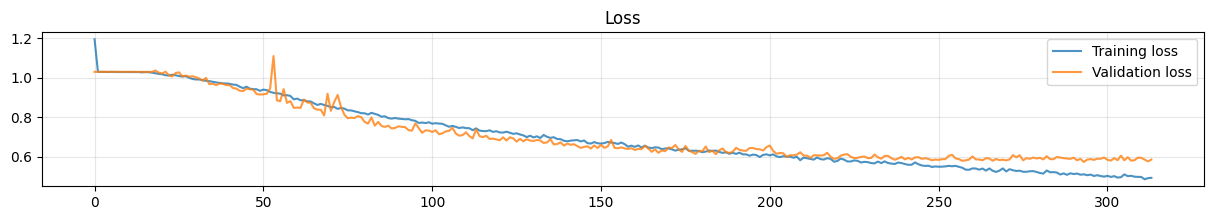

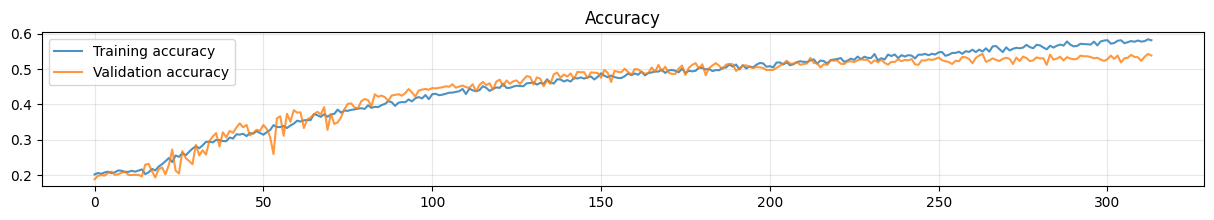

In [20]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [22]:
print(X_test.shape)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
accuracy = round(test_accuracy, 4)
print(f'Test Accuracy: {accuracy}')

model.save(f"/kaggle/working/CustomCNN_{accuracy}.keras")

(4764, 138, 138, 1)
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5323 - loss: 0.5870
Test Accuracy: 0.5225


149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy score over the test set: 0.5225
Precision score over the test set: 0.5386
Recall score over the test set: 0.5225
F1 score over the test set: 0.5275


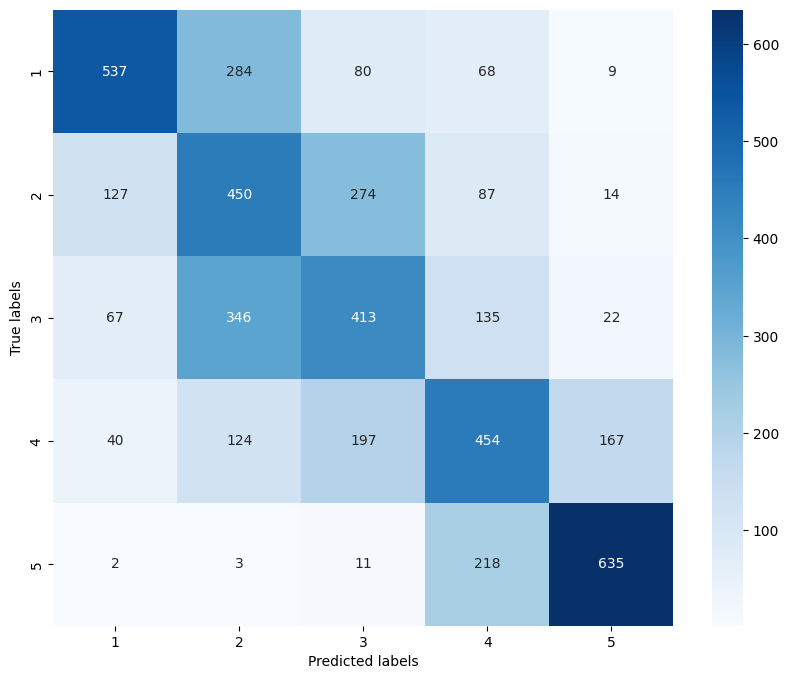

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

classes = [1, 2, 3, 4, 5]

predictions = model.predict(X_test)

# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=annot, fmt=".4", xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()